# Bayesian Parameter Estimation on MBL Data with sigma for each induction
## Nathan Belliveau, Griffin Chure, Manuel Razo
**July 8, 2016**

In [33]:
import numpy as np
import pandas as pd
import emcee
import scipy.special
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import warnings
import seaborn as sns
import corner
rc = {'lines.linewidth': 1.5,
      'axes.labelsize' : 14,
      'axes.titlesize' : 18,
      'axes.facecolor' : 'EBEBEB',
      'axes.edgecolor' : '000000',
      'axes.linewidth' : 0.75,
      'axes.frameon' : True,
      'xtick.labelsize' : 11,
      'ytick.labelsize' : 11,
      'font.family' : 'Droid Sans',
      'grid.linestyle' : ':',
      'grid.color' : 'a6a6a6',
      'mathtext.fontset' : 'stixsans',
      'mathtext.sf' : 'sans'}
plt.rc('text.latex', preamble=r'\usepackage{sfmath}')
plt.rc('mathtext', fontset='stixsans', sf='sans') 
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)
sns.set_palette("deep", color_codes=True)

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

#------------------------------------------------------------------------------- 
%matplotlib notebook

# Trying to sample $K_A$ and $K_I$ in log space 

In [34]:
#Load the data. 
data = pd.read_csv('../../data/mbl_2016/MBL_fc_data.csv')

#let's reformat the data to make it work with emcee (there must be a better way...)
rbs_0 = data[(data.strain=='1027') & (data.epsilon_r==-13.9) & (data.IPTG==0.0000)]
rbs_00001 = data[(data.strain=='1027') & (data.epsilon_r==-13.9) & (data.IPTG==0.0001)]
rbs_0001 = data[(data.strain=='1027') & (data.epsilon_r==-13.9) & (data.IPTG==0.001)]
rbs_0005 = data[(data.strain=='1027') & (data.epsilon_r==-13.9) & (data.IPTG==0.005)]
rbs_001 = data[(data.strain=='1027') & (data.epsilon_r==-13.9) & (data.IPTG==0.01)]
rbs_0025 = data[(data.strain=='1027') & (data.epsilon_r==-13.9) & (data.IPTG==0.025)]
rbs_005 = data[(data.strain=='1027') & (data.epsilon_r==-13.9) & (data.IPTG==0.05)]
rbs_0075 = data[(data.strain=='1027') & (data.epsilon_r==-13.9) & (data.IPTG==0.075)]
rbs_01 = data[(data.strain=='1027') & (data.epsilon_r==-13.9) & (data.IPTG==0.1)]
rbs_025 = data[(data.strain=='1027') & (data.epsilon_r==-13.9) & (data.IPTG==0.25)]
rbs_05 = data[(data.strain=='1027') & (data.epsilon_r==-13.9) & (data.IPTG==0.5)]
rbs_1 = data[(data.strain=='1027') & (data.epsilon_r==-13.9) & (data.IPTG==1.0)]
rbs_5 = data[(data.strain=='1027') & (data.epsilon_r==-13.9) & (data.IPTG==5.0)]


In [35]:
rbs_IPTG = [rbs_0.IPTG,rbs_00001.IPTG, rbs_0001.IPTG, rbs_0005.IPTG, rbs_001.IPTG, \
       rbs_0025.IPTG, rbs_005.IPTG, rbs_0075.IPTG, rbs_01.IPTG, \
       rbs_025.IPTG, rbs_05.IPTG,rbs_1.IPTG, rbs_5.IPTG]
rbs_fc = [rbs_0.fold_change, rbs_00001.fold_change, rbs_0001.fold_change, rbs_0005.fold_change, rbs_001.fold_change, \
       rbs_0025.fold_change,rbs_005.fold_change, rbs_0075.fold_change, rbs_01.fold_change, \
       rbs_025.fold_change, rbs_05.fold_change,rbs_1.fold_change, rbs_5.fold_change]

In [29]:
rbs = data[(data.strain=='1027') & (data.epsilon_r==-13.9) ]

In [36]:
# define a funciton to compute the fold change as a funciton of IPTG
def pact_log(IPTG, ea, ei, epsilon):
    '''
    Returns the probability of a repressor being active as described by the MWC
    model.
    Parameter
    ---------
    IPTG : array-like.
        concentrations of inducer on which to evaluate the function
    epsilon : float.
        energy difference between the active and the inactive state
    Returns
    -------
    pact : float.
        probability of a repressor of being in the active state. Active state is
        defined as the state that can bind to the DNA.
    '''
    pact = (1.0 + IPTG * np.exp(ea))**2.0 / \
    ((1.0 + IPTG * np.exp(ea))**2.0 + np.exp(-epsilon) * (1.0 + IPTG * np.exp(ei))**2.0)
    return pact



In [84]:
def fold_change_log(IPTG, ea, ei, epsilon, R, epsilon_r):
    '''
    Returns the gene expression fold change according to the thermodynamic model
    with the extension that takes into account the effect of the inducer.
    Parameter
    ---------
    IPTG : array-like.
        concentrations of inducer on which to evaluate the function
    epsilon : float.
        energy difference between the active and the inactive state
    R : array-like.
        repressor copy number for each of the strains. The length of this array
        should be equal to the IPTG array. If only one value of the repressor is
        given it is asssume that all the data points should be evaluated with
        the same repressor copy number
    epsilon_r : array-like
        repressor binding energy. The length of this array
        should be equal to the IPTG array. If only one value of the binding
        energy is given it is asssume that all the data points 
        should be evaluated with the same repressor copy number
        
    Returns
    -------
    fold-change : float.
        gene expression fold change as dictated by the thermodynamic model.
   '''
    return 1.0 / (1.0 + 2.0 * R / 5.0E6 * pact_log(IPTG, ea, ei, epsilon) * \
            (1.0 + np.exp(-epsilon)) * np.exp(-epsilon_r))

In [103]:
def log_likelihood_log(param, IPTG, fc, R, ep_r, ep_ai):
    """
    Computes the log likelihood.
    """
    #Unpack the parameters.
    
    ea, ei= param[:2]
    sigma = param[2:] 

    log_like = 0
    for i in range(0,len(sigma)):
        fc_theo = fold_change_log(IPTG[i], ea, ei, ep_ai, R, ep_r) 
        log_like = log_like + len(IPTG[i])*np.log(sigma[i]) - np.sum((fc[i]-fc_theo)**2) / 2 / sigma[i]**2
    return log_like
   

def log_post_log(param, IPTG,fc, R, ep_r, ep_ai):
    ea, ei= param[:2]
    sigma = param[2:] 
    
    if ea > 20 or ea < 0 or ei > 20 or ei < 0 or np.min(sigma) < 0 or np.max(sigma) > 0.01: 
        return -np.inf

    return log_likelihood_log(param, IPTG, fc, R, ep_r, ep_ai)

In [107]:
#Define the parameters for emcee
n_dim = 15
n_walkers = 50 #1000
n_burn = 1000
n_steps = 1000 
p0 = np.empty((n_walkers, n_dim))
p0[:,0] = np.random.uniform(0, 20, n_walkers)
p0[:,1] = np.random.uniform(0, 20, n_walkers)

p0[:,2:] = np.random.uniform(0, 0.01, [n_walkers,13])


In [108]:
#Call the sampler. 
sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_post_log,\
                args=(rbs_IPTG,rbs_fc, 130, -13.9, 4.5),\
                threads=6)

In [109]:
#Do the burn in 
pos, prob, state = sampler.run_mcmc(p0, n_burn, storechain=False)

In [110]:
_ = sampler.run_mcmc(pos, n_steps)

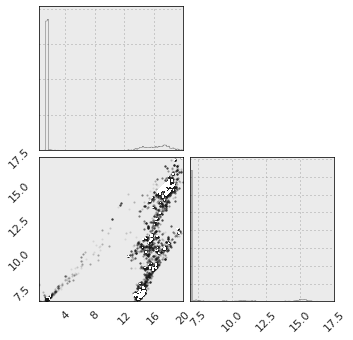

In [111]:
fig = corner.corner(sampler.flatchain[:,0:2], bins=100, plot_contours=False)

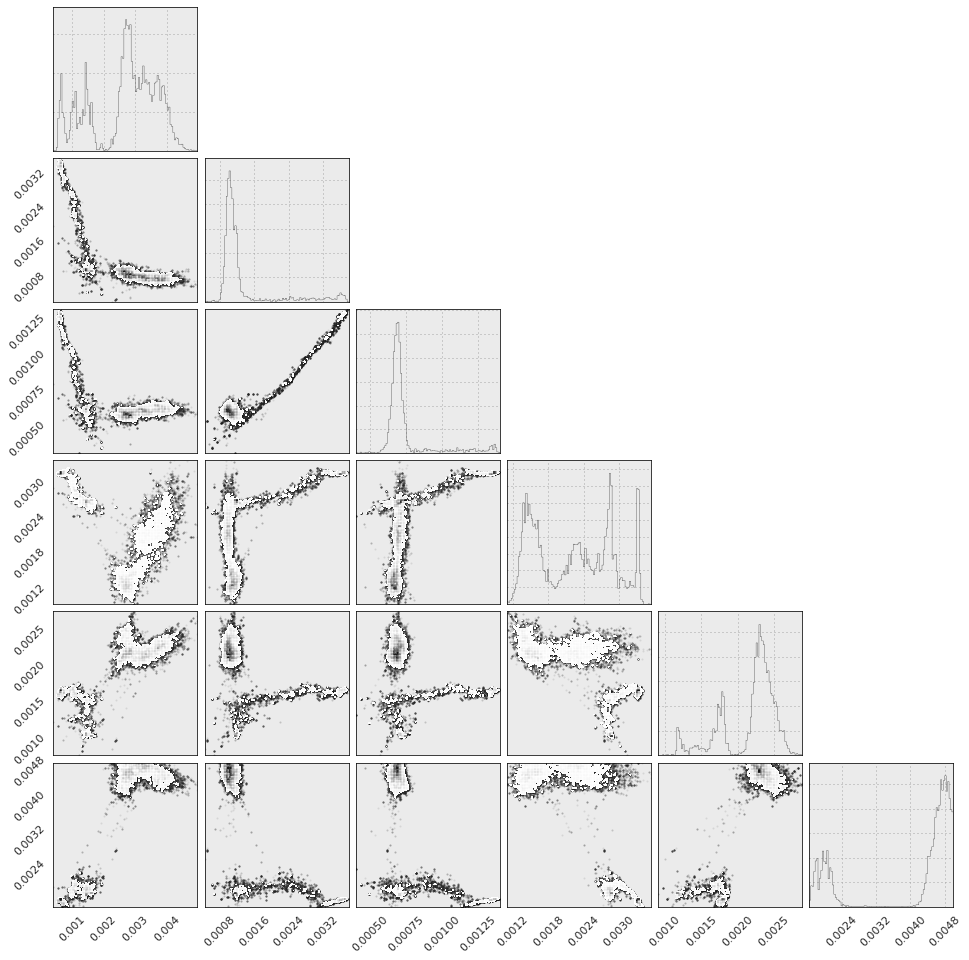

In [112]:
fig = corner.corner(sampler.flatchain[:,2:8], bins=100, plot_contours=False)

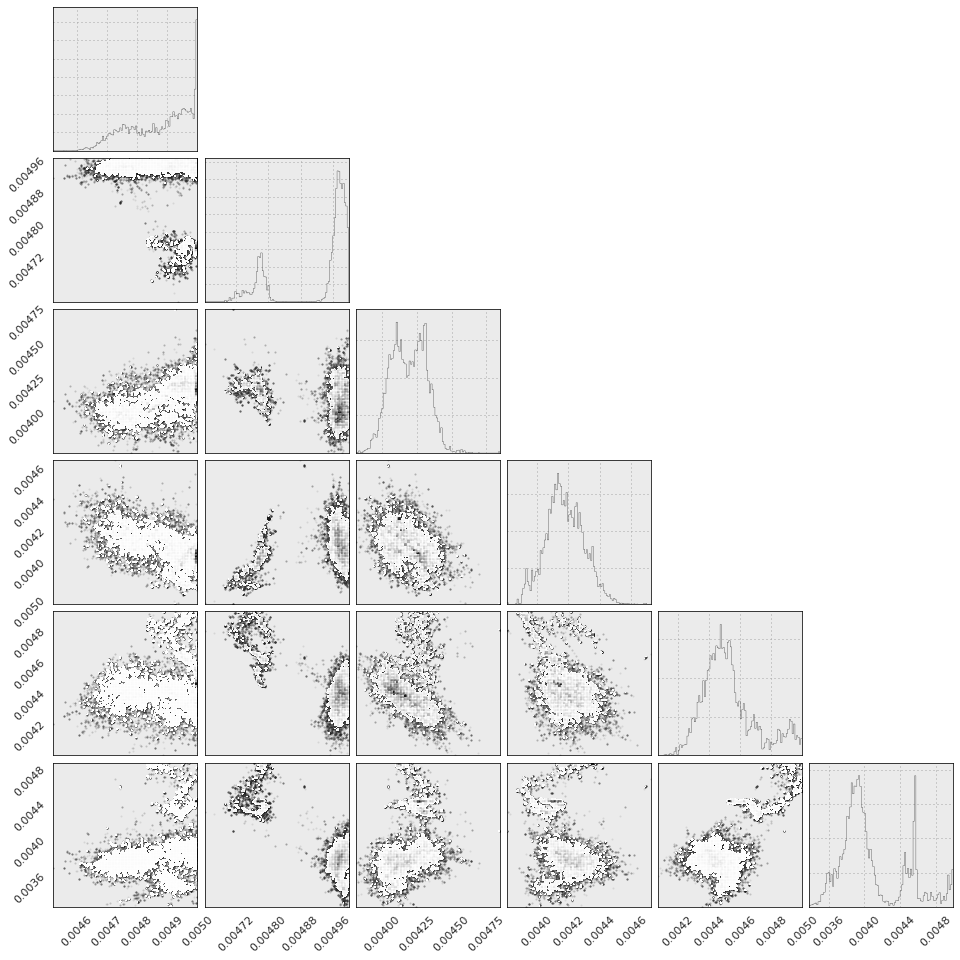

In [113]:
fig = corner.corner(sampler.flatchain[:,8:14], bins=100, plot_contours=False)

In [16]:
#samples = sampler.chain[:, :, :].reshape((-1, n_dim))
#np.savetxt('MCMC_1027_.csv',samples)
#samples = np.loadtxt('MCMC_1027.csv')

In [118]:
ea = np.mean(sampler.flatchain[:,0][sampler.flatchain[:, 0] < 4])
ei = np.mean(sampler.flatchain[:,1][sampler.flatchain[:, 1] <8])

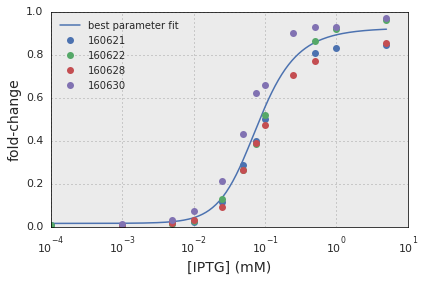

In [119]:
IPTG = np.logspace(-4, np.log10(5), 200)
fc_theory = fold_change_log(IPTG, ea, ei, 4.5, R=130, epsilon_r=-13.9)

plt.figure()
plt.plot(IPTG, fc_theory, '-b', label='best parameter fit')
for date in rbs.date.unique():
    plt.plot(rbs[rbs.date==date].IPTG, rbs[rbs.date==date].fold_change, 'o',
            label=str(date))
plt.xscale('log')
plt.xlabel('[IPTG] (mM)')
plt.ylabel('fold-change')
plt.legend(loc='upper left')
plt.tight_layout()

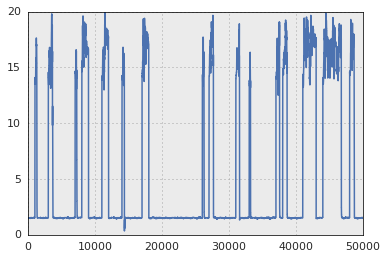

In [122]:
%matplotlib inline
plt.plot(sampler.flatchain[:, 0])


In [121]:
# Print results
print("""
The most probable parameters for the MWC model
----------------------------------------------
Ka = {0:.2f} mM
Ki = {1:.5f} mM
""".format(np.exp(-ea), np.exp(-ei)))


The most probable parameters for the MWC model
----------------------------------------------
Ka = 0.22 mM
Ki = 0.00086 mM

